In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier

from MLBDataFetcher import MLBDataFetcher
from preprocess import Att_Analysis
from InterruptedTimeSeries import ITS, MITS

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# <a id='toc1_'></a>[中断時系列分析をする](#toc0_)

## <a id='toc1_1_'></a>[データ準備](#toc0_)

正味コロナデータの準備もクラスに入れたい

In [39]:
game_df = pd.read_csv('./data/monthly_average_game_time.csv')
game_df =game_df.set_index('Unnamed: 0').rename_axis('Date').reset_index()
# game_dfのdateを変換
game_df['Date'] = pd.to_datetime(game_df['Date'], format='%Y/%m/1')
# 日付はいらない。月だけでいい
game_df['Date'] = game_df['Date'].dt.strftime('%Y-%m')

# game_df.set_index('date', inplace=True)
# game_df.index.name = None
game_df['Date'] = pd.to_datetime(game_df['Date'], format='%Y-%m')

game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 54 non-null     datetime64[ns]
 1   Game Time (minutes)  54 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 996.0 bytes


In [2]:
# コロナのデータを確認
covid_new_cases_df = pd.read_csv('./data/new_cases.csv')
covid_new_death_df = pd.read_csv('./data/new_deaths.csv')
# 年-月の形式に変換
covid_new_cases_df['Date'] = pd.to_datetime(covid_new_cases_df['Date'], format='%Y/%m/%d')
covid_new_death_df['Date'] = pd.to_datetime(covid_new_death_df['Date'], format='%Y/%m/%d')
# Dateをindexに設定
covid_new_cases_df.set_index('Date', inplace=True)
covid_new_death_df.set_index('Date', inplace=True)
# 年-月の形式に変換
# covid_new_cases_df['Date'] = pd.to_datetime(covid_new_cases_df['Date'], format='%Y-%m')

covid_new_cases_df.reset_index(inplace=True)
covid_new_death_df.reset_index(inplace=True)

In [33]:
covid_new_cases_df

,Date,new_cases
0,2013-04-01,0
1,2013-05-01,0
2,2013-06-01,0
3,2013-07-01,0
4,2013-08-01,0
...,...,...
61,2023-05-01,170425
62,2023-06-01,0
63,2023-07-01,0
64,2023-08-01,0


In [2]:
att_remove_covid_addup = Att_Analysis(is_remove_covid=True, is_addup=True, how_completion_outlier='with_predict')
df_att_remove_covid_addup = att_remove_covid_addup.get_monthly_all_df()
# df_att_remove_covid_addup = att_remove_covid_addup.merge_new_df(game_df)
# df_att_remove_covid_addup = att_remove_covid_addup.merge_new_df(covid_new_cases_df)
# df_att_remove_covid_addup = att_remove_covid_addup.merge_new_df(covid_new_death_df) #? コロナデータ入れない方が良いかも。。。

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29988D+01    |proj g|=  2.06281D+00

At iterate    5    f=  1.23400D+01    |proj g|=  1.28532D-01

At iterate   10    f=  1.22608D+01    |proj g|=  9.35530D-02

At iterate   15    f=  1.22243D+01    |proj g|=  1.57222D-01

At iterate   20    f=  1.22021D+01    |proj g|=  1.08947D-01

At iterate   25    f=  1.22013D+01    |proj g|=  6.39626D-03

At iterate   30    f=  1.22006D+01    |proj g|=  1.02883D-01

At iterate   35    f=  1.21992D+01    |proj g|=  2.35841D-02

At iterate   40    f=  1.21986D+01    |proj g|=  7.89498D-03

At iterate   45    f=  1.21969D+01    |proj g|=  6.38762D-03

At iterate   50    f=  1.21951D+01    |proj g|=  1.73677D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## <a id='toc1_2_'></a>[分析](#toc0_)

In [4]:
its_periodical_OLS = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True)
its_periodical_OLS.show_summary()

seed値:0


/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(0, 2, 3)x(0, 2, 3, 6)   Log Likelihood                -613.427
Date:                           Wed, 22 Nov 2023   AIC                           1246.854
Time:                                   17:07:50   BIC                           1263.743
Sample:                                        0   HQIC                          1252.961
                                            - 54                                         
Covariance Type:                             opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
time since start -2.009e-07   2.12e+04  -9.49e-12      1.000   -4.15e+04    4.15e+04
level change 0    1.344e+06   1.16e+06      1.162      0.245   -9.23e+05    3.61e+06
slope change 0   -4.157e+06   1.25e+06     -3.334      0.001    -6.6e+06   -1.71e+06
ma.L1               -0.8480      0.338     -2.506      0.012      -1.511      -0.185
ma.L2                0.4899      0.413      1.185      0.236      -0.320       1.300
ma.L3               -0.0744      0.288     -0.258      0.796      -0.638       0.490
ma.S.L6             -0.7951      0.328     -2.421      0.015      -1.439      -0.151
ma.S.L12            -0.0495      0.195     -0.254      0.799      -0.431       0.332
ma.S.L18            -0.0669      0.145     -0.460      0.645      -0.352       0.218
sigma2             1.53e+12      0.111   1.38e+13      0.000    1.53e+12    1.53e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.95   Prob(JB):                         0.96
Heteroskedasticity (H):               1.08   Skew:                            -0.03
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.67e+31. Standard errors may be unstable.
"""

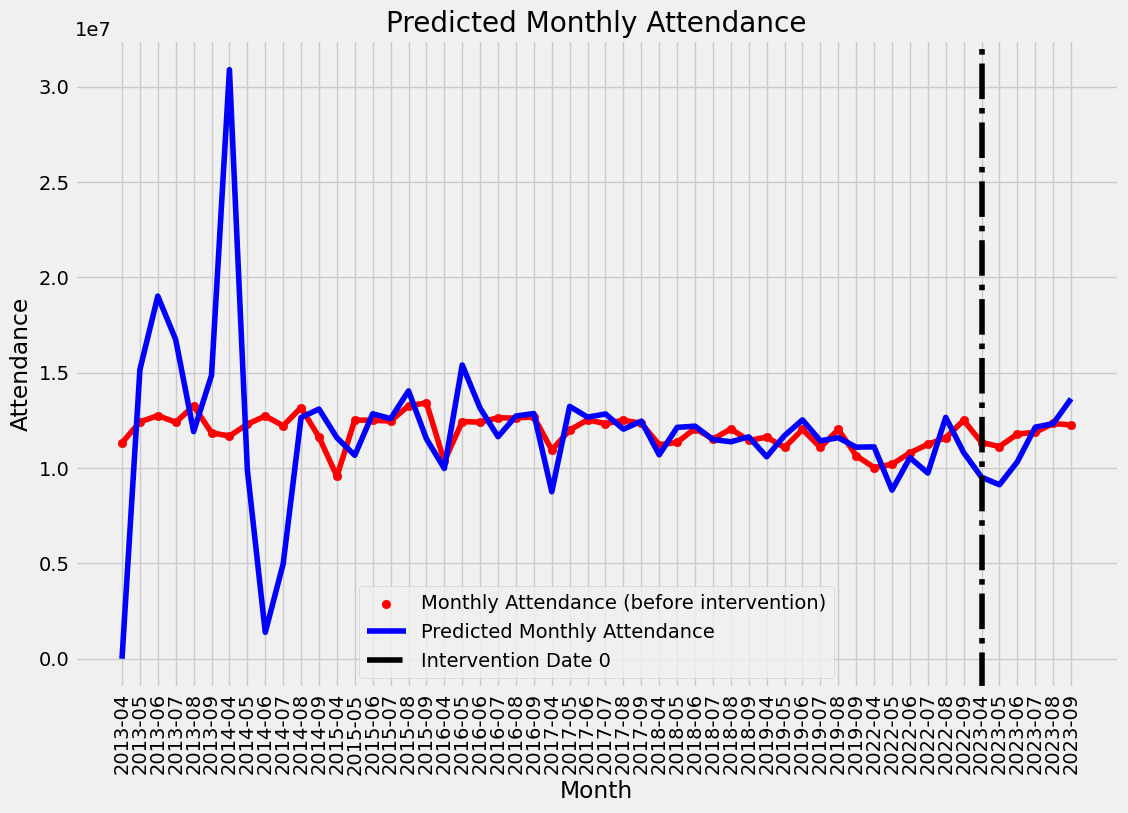

In [5]:
its_periodical_OLS.plot_predict()

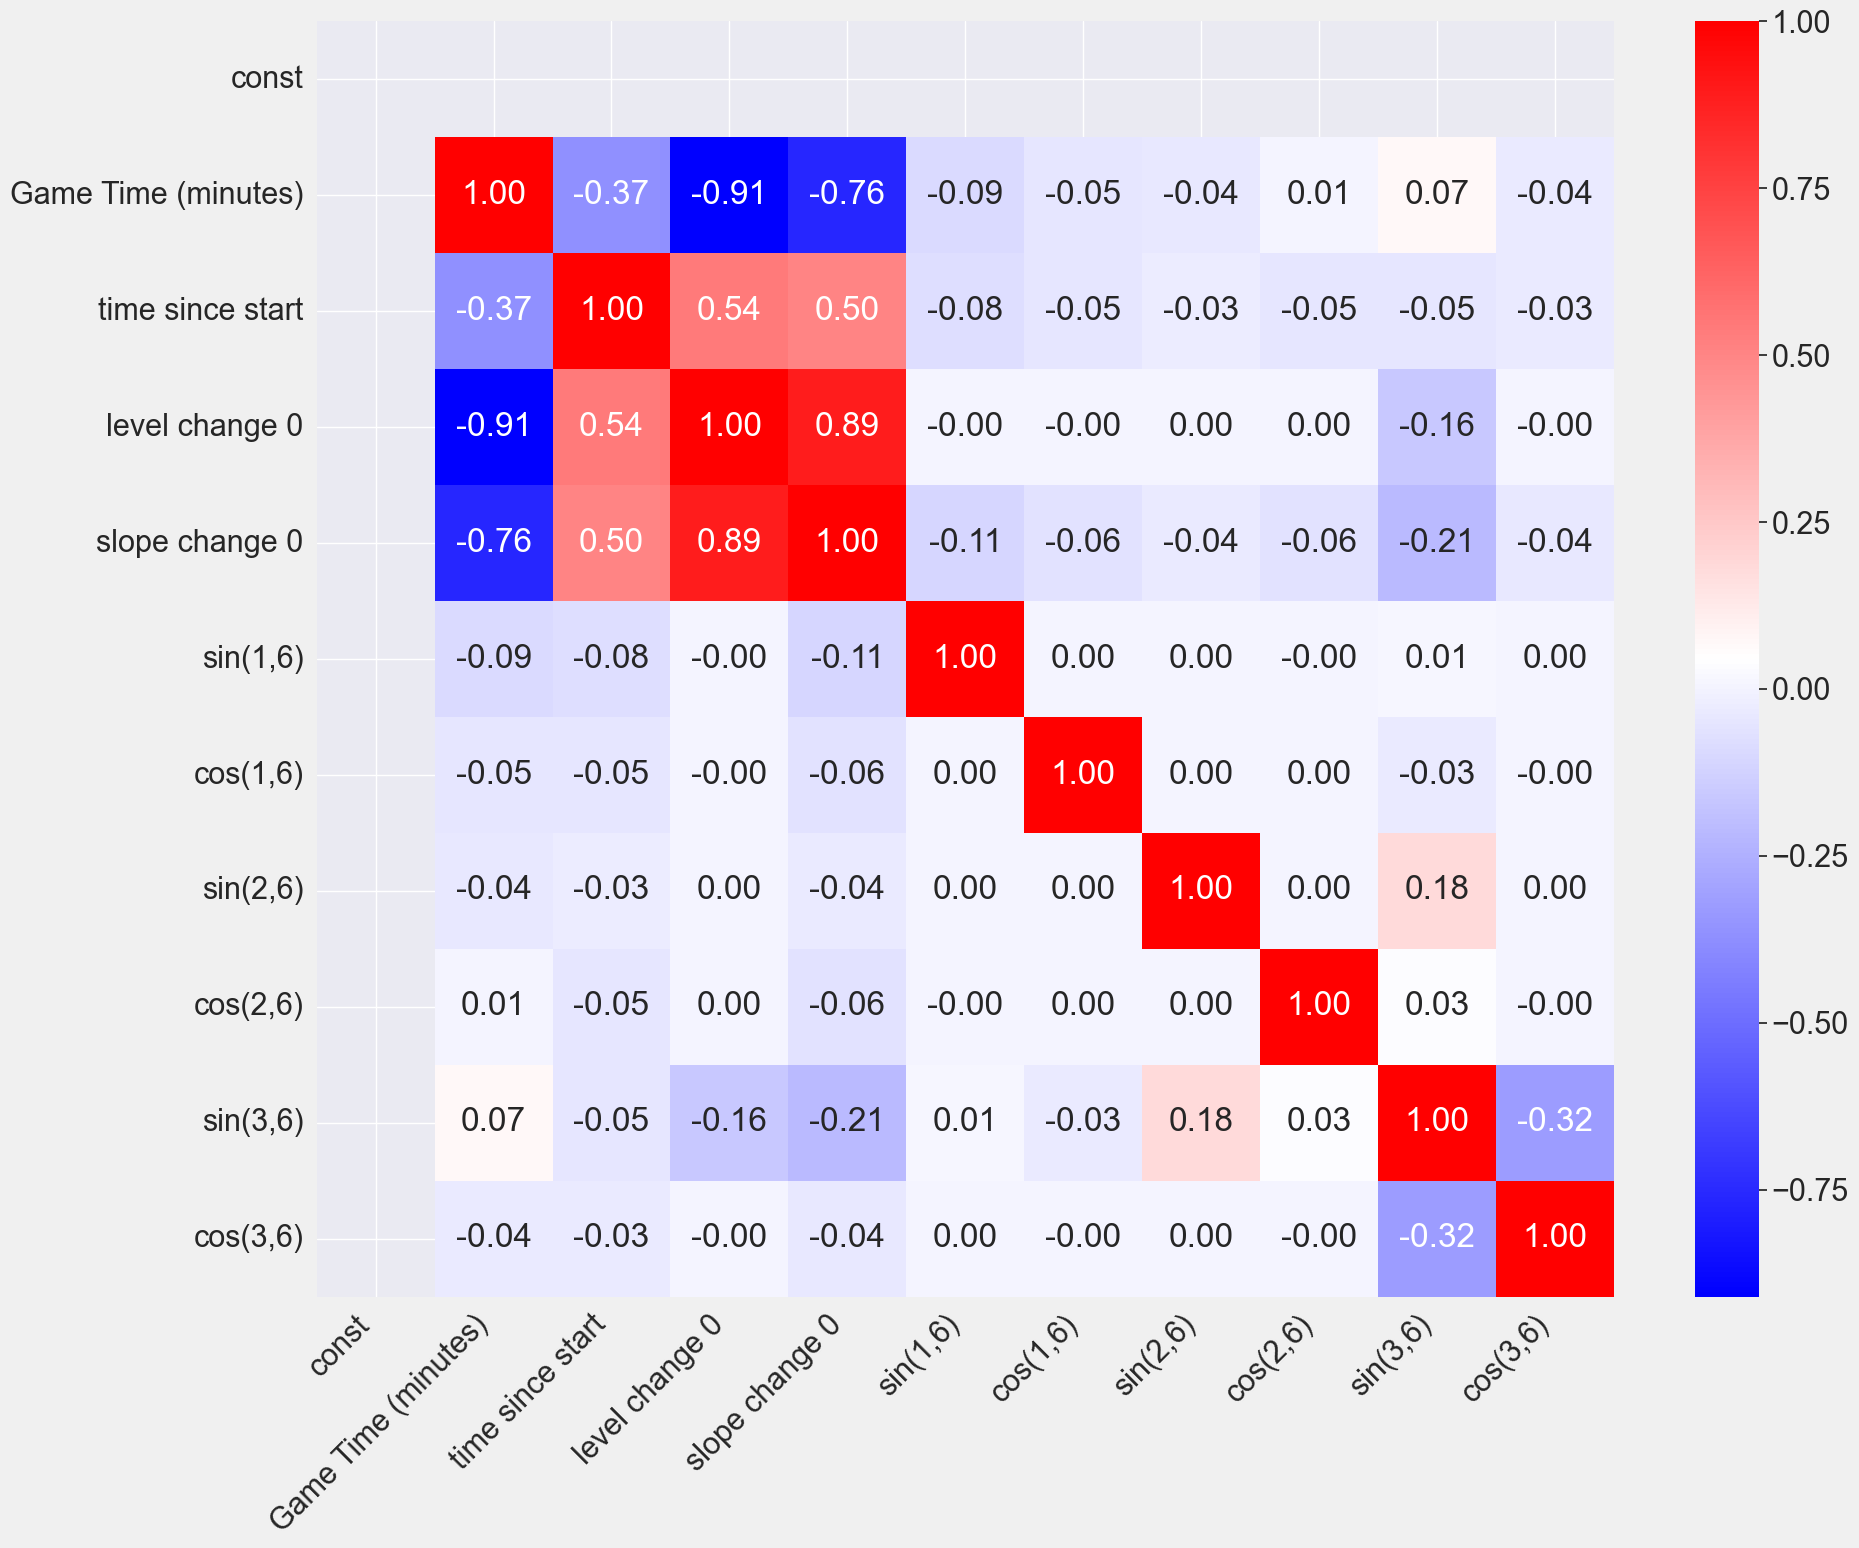

VIF: [3778.4465801835654, 7.5235015999759325, 1.6551926006518642, 15.340741732420728, 5.4983040914622086, 1.1043972272213118, 1.0330874703884356, 1.014394755268844, 1.028591518105651, 1.3126026150811627, 1.0165437351942177]


In [45]:
its_periodical_OLS.show_correlation()

多重共線性えぐいやん。てか当たり前か笑

In [23]:
its_periodical_OLS.fit_slope_after_intervention()

                            OLS Regression Results                            
Dep. Variable:             Attendance   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     4.138
Date:                Mon, 13 Nov 2023   Prob (F-statistic):             0.0107
Time:                        11:32:53   Log-Likelihood:                -813.21
No. Observations:                  54   AIC:                             1634.
Df Residuals:                      50   BIC:                             1642.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.26

In [23]:
# 使うDFを変える
df_att_remove_covid = Att_Analysis(is_remove_covid=True, is_addup=False).df_monthly_att_all_covid_removed
its_periodical_OLS = ITS(df_att_remove_covid, intervention='2023-04', method='Periodic OLS', period=8, order=3)
its_periodical_OLS.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.240
Date:                Mon, 23 Oct 2023   Prob (F-statistic):              0.288
Time:                        18:01:35   Log-Likelihood:                -1211.9
No. Observations:                  73   AIC:                             2444.
Df Residuals:                      63   BIC:                             2467.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.075e+07   1.03e+06     10.442      0.000     8.7e+06    1.28e+07
time since start -2.924e+04   2.74e+04     -1.069      0.289   -8.39e+04    2.54e+04
level change       4.51e+06    3.2e+06      1.411      0.163   -1.88e+06    1.09e+07
slope change     -1.063e+06   8.45e+05     -1.258      0.213   -2.75e+06    6.25e+05
sin(1,8)         -1.321e+06   7.24e+05     -1.826      0.073   -2.77e+06    1.25e+05
sin(2,8)          1.109e+06   7.05e+05      1.572      0.121   -3.01e+05    2.52e+06
sin(3,8)           3.14e+05   7.05e+05      0.445      0.658   -1.09e+06    1.72e+06
cos(1,8)         -5.582e+05   7.13e+05     -0.783      0.436   -1.98e+06    8.66e+05
cos(2,8)         -6.591e+05      7e+05     -0.941      0.350   -2.06e+06     7.4e+05
cos(3,8)           -6.1e+05   6.96e+05     -0.877      0.384      -2e+06    7.81e+05
==============================================================================
Omnibus:                       13.868   Durbin-Watson:                   1.305
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.864
Skew:                          -1.133   Prob(JB):                     0.000359
Kurtosis:                       3.284   Cond. No.                         277.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

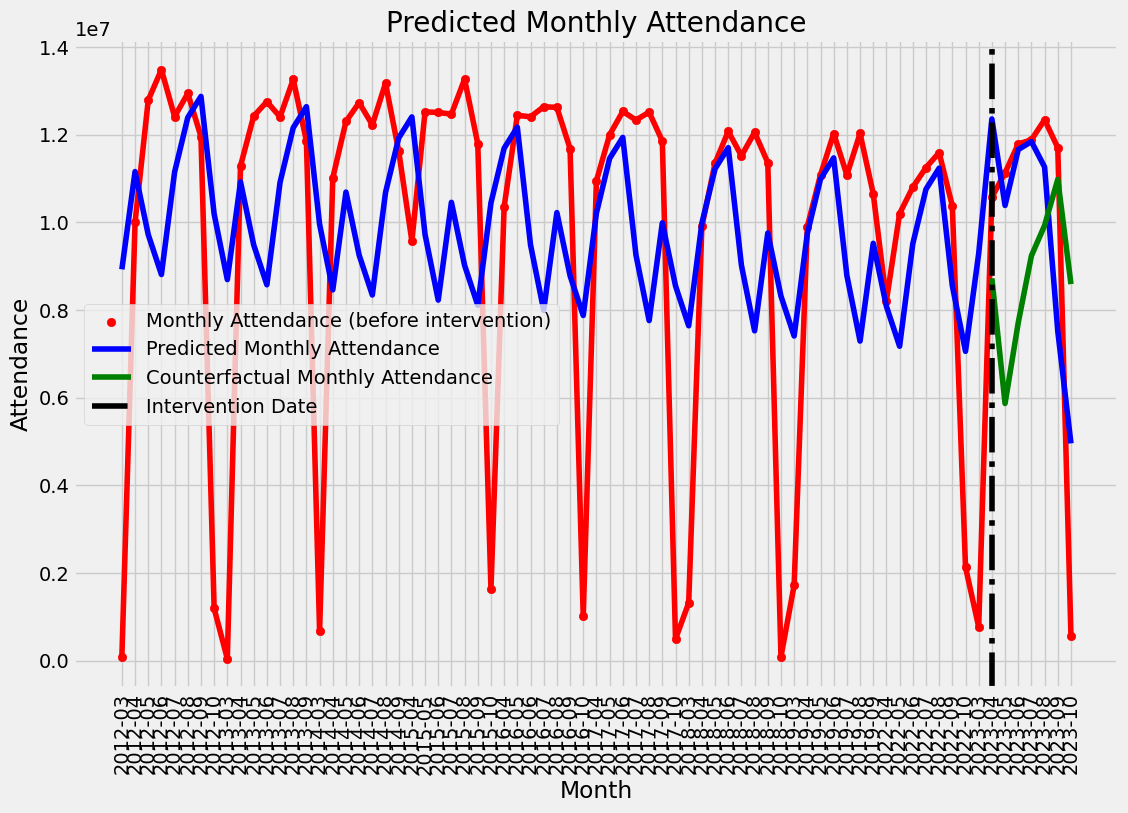

In [24]:
its_periodical_OLS.plot_predict(is_counterfactual=True)

In [6]:
## 多重共線性の確認
X = its_periodical_OLS.X
X = sm.add_constant(X)
X

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

its_periodical_OLS.plot_predict(is_counterfactual=True, is_prediction_std=True)

its_periodical_OLS.show_summary()


AttributeError: 'MITS' object has no attribute 'X'

## SARIMAXで中断時系列分析


In [46]:
its_sarimax = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='SARIMAX', optim_params_sarimax=True, seed=7)

In [47]:
its_sarimax.show_summary()

seed値:7


/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal m

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                        Attendance   No. Observations:                   54
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 6)   Log Likelihood                -711.857
Date:                           Mon, 13 Nov 2023   AIC                           1447.713
Time:                                   11:42:53   BIC                           1469.915
Sample:                                        0   HQIC                          1456.068
                                            - 54                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Game Time (minutes)   1.61e+04   3.97e+04      0.405      0.685   -6.18e+04     9.4e+04
time since start    -1.695e-05   8502.124  -1.99e-09      1.000   -1.67e+04    1.67e+04
level change 0       2.282e+06    169.133   1.35e+04      0.000    2.28e+06    2.28e+06
slope change 0       -7.14e+05    660.390  -1081.134      0.000   -7.15e+05   -7.13e+05
ar.L1                  -0.8340      0.527     -1.583      0.113      -1.866       0.198
ma.L1                   0.6601      0.530      1.246      0.213      -0.378       1.699
ma.L2                  -0.0645      0.203     -0.317      0.751      -0.463       0.334
ar.S.L6                -0.2649      0.718     -0.369      0.712      -1.672       1.142
ar.S.L12                0.7271      0.380      1.914      0.056      -0.018       1.472
ma.S.L6                -0.0142      1.500     -0.009      0.992      -2.955       2.927
ma.S.L12               -0.9857      0.648     -1.521      0.128      -2.256       0.284
sigma2               8.125e+11   6.67e-07   1.22e+18      0.000    8.12e+11    8.12e+11
===================================================================================
Ljung-Box (L1) (Q):                   3.37   Jarque-Bera (JB):                 2.29
Prob(Q):                              0.07   Prob(JB):                         0.32
Heteroskedasticity (H):               1.37   Skew:                            -0.19
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.2e+37. Standard errors may be unstable.
"""

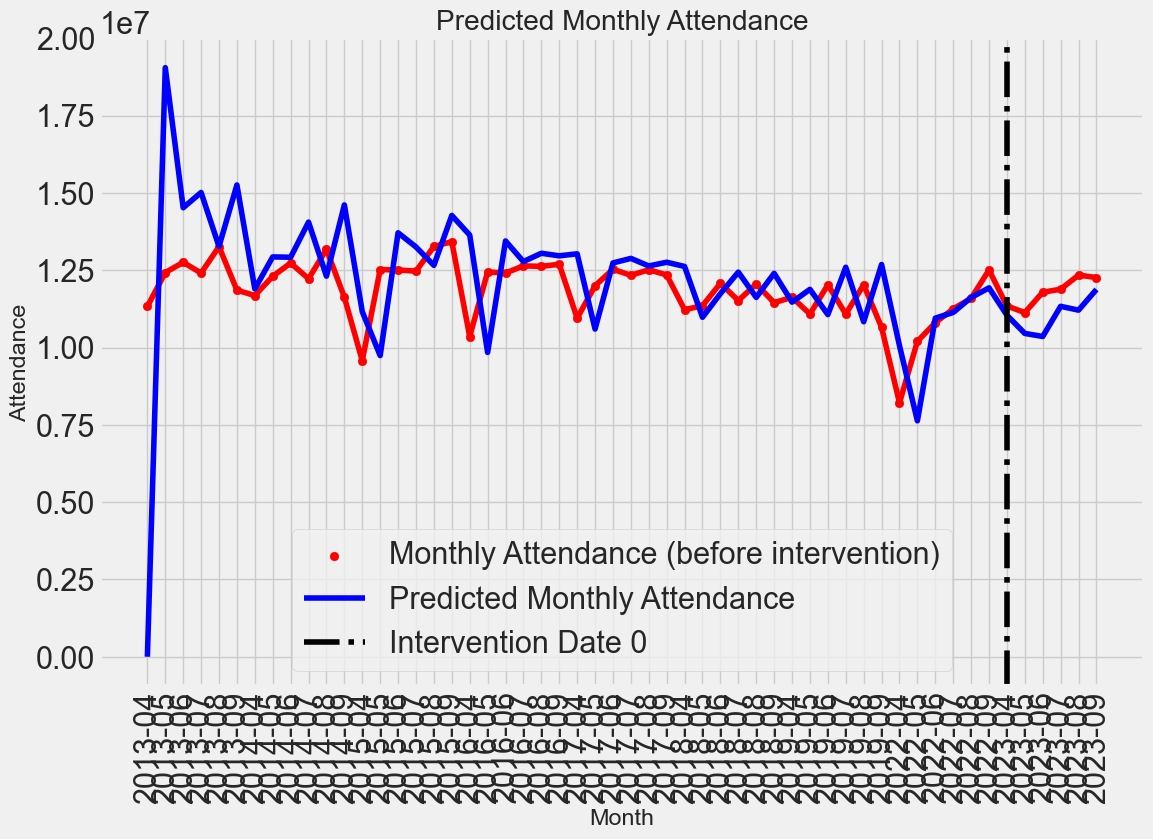

In [44]:
its_sarimax.plot_predict()

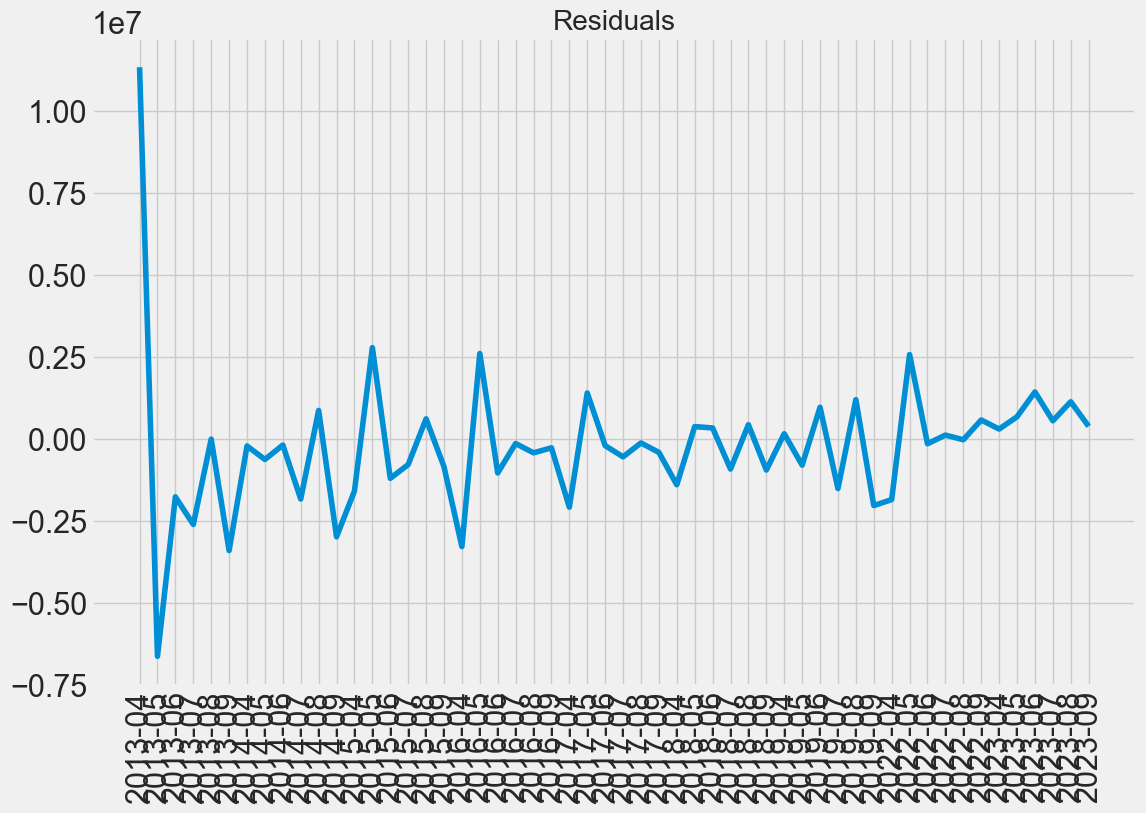

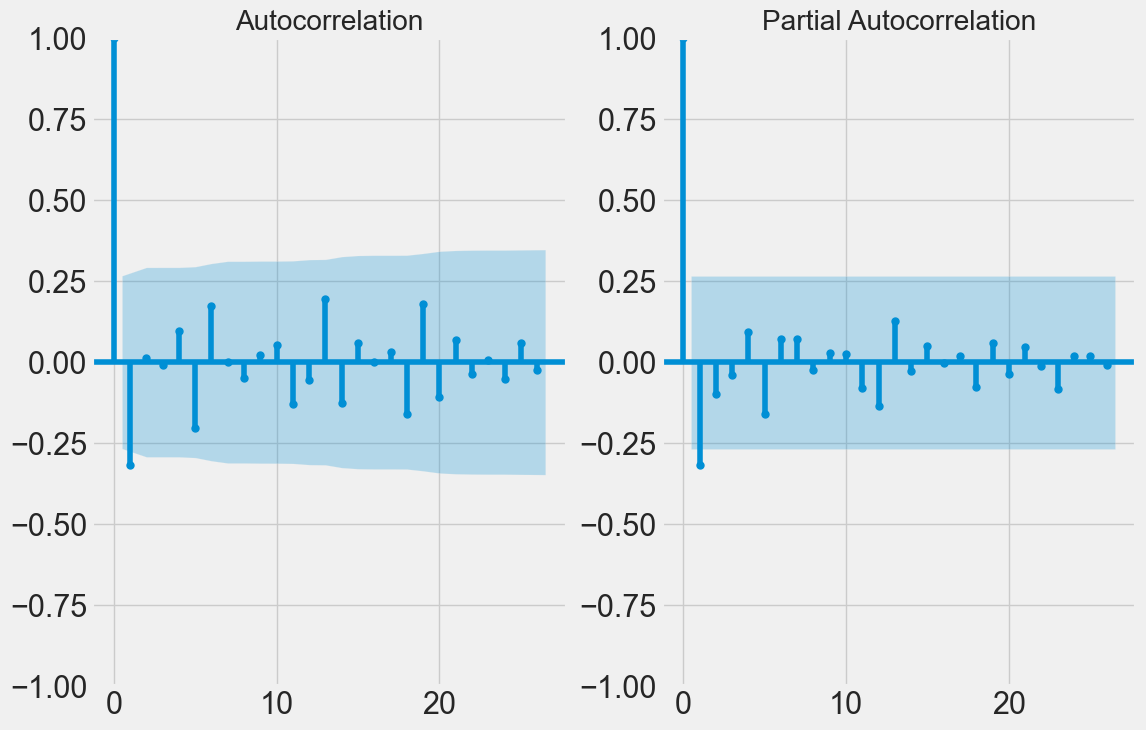

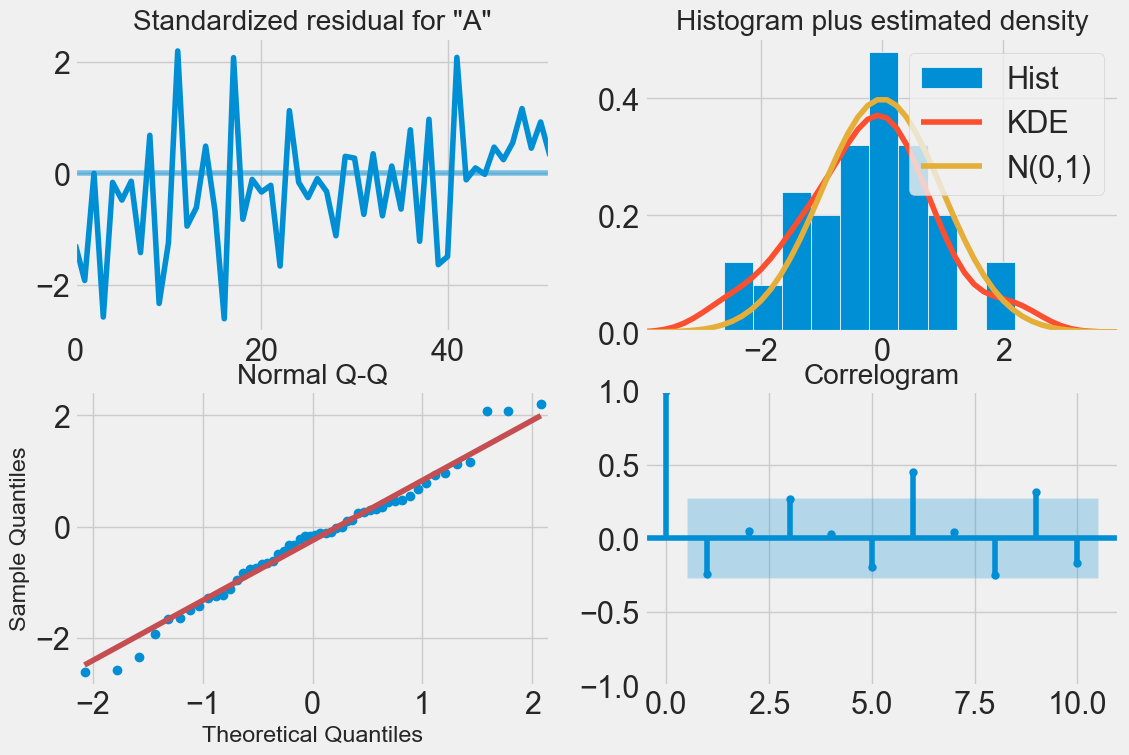

In [45]:
its_sarimax.plot_sarimax_params()

## ARIMAXで中断時系列分析

In [48]:
its_sarimax = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='ARIMAX', optim_params_arimax=True)
its_sarimax.show_summary()

seed値:0


/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mototsuguohki/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Attendance   No. Observations:                   54
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -806.902
Date:                Mon, 13 Nov 2023   AIC                           1631.803
Time:                        11:58:37   BIC                           1649.365
Sample:                             0   HQIC                          1638.536
                                 - 54                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Game Time (minutes)   1.74e+04   1.94e+04      0.899      0.369   -2.05e+04    5.53e+04
time since start       -0.0032   2.16e+04  -1.49e-07      1.000   -4.23e+04    4.23e+04
level change 0      -4.805e+05   8.52e+04     -5.639      0.000   -6.47e+05   -3.13e+05
slope change 0      -1.217e+06   7.99e+05     -1.522      0.128   -2.78e+06     3.5e+05
ar.L1                  -0.7718      0.168     -4.604      0.000      -1.100      -0.443
ar.L2                   0.1550      0.184      0.842      0.400      -0.206       0.516
ma.L1                2.781e-05    182.684   1.52e-07      1.000    -358.054     358.054
ma.L2                  -1.0000      0.228     -4.383      0.000      -1.447      -0.553
sigma2               1.351e+12   1.03e-09   1.31e+21      0.000    1.35e+12    1.35e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.51   Jarque-Bera (JB):                 0.27
Prob(Q):                              0.22   Prob(JB):                         0.88
Heteroskedasticity (H):               0.46   Skew:                            -0.17
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.4e+45. Standard errors may be unstable.
"""

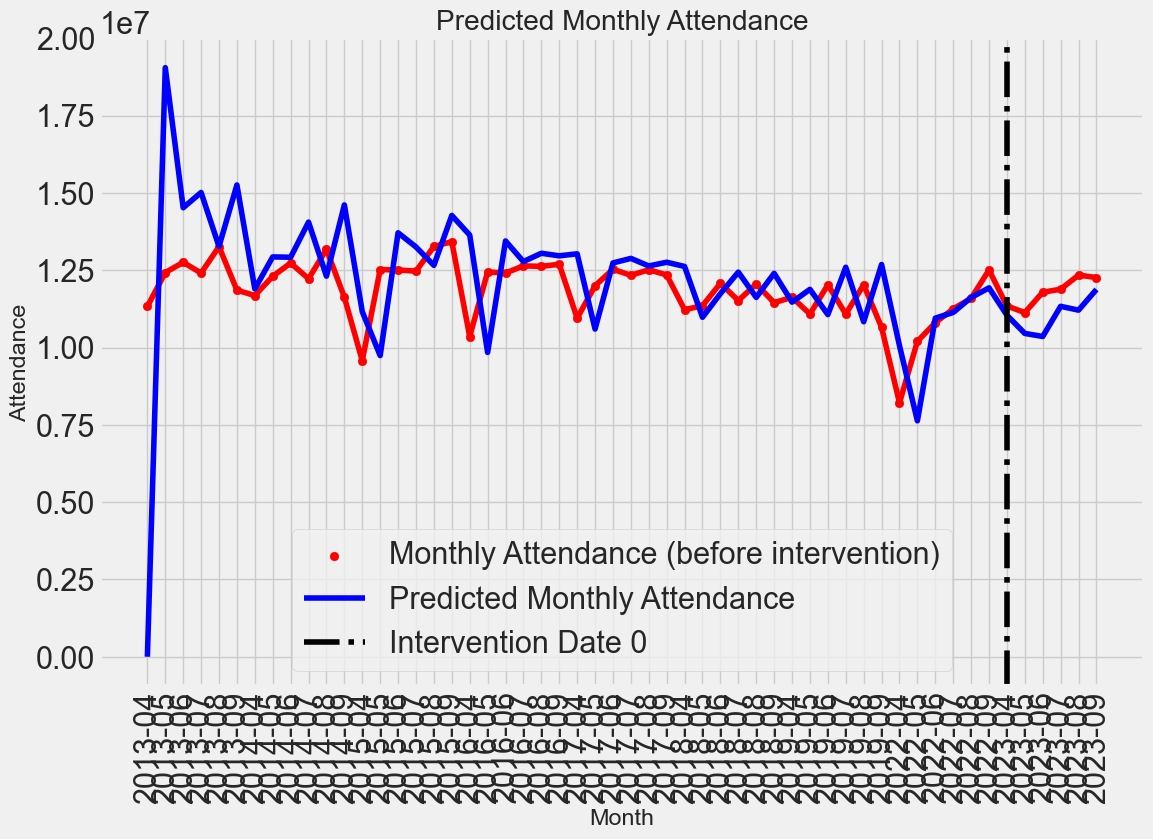

In [47]:
its_sarimax.plot_predict()


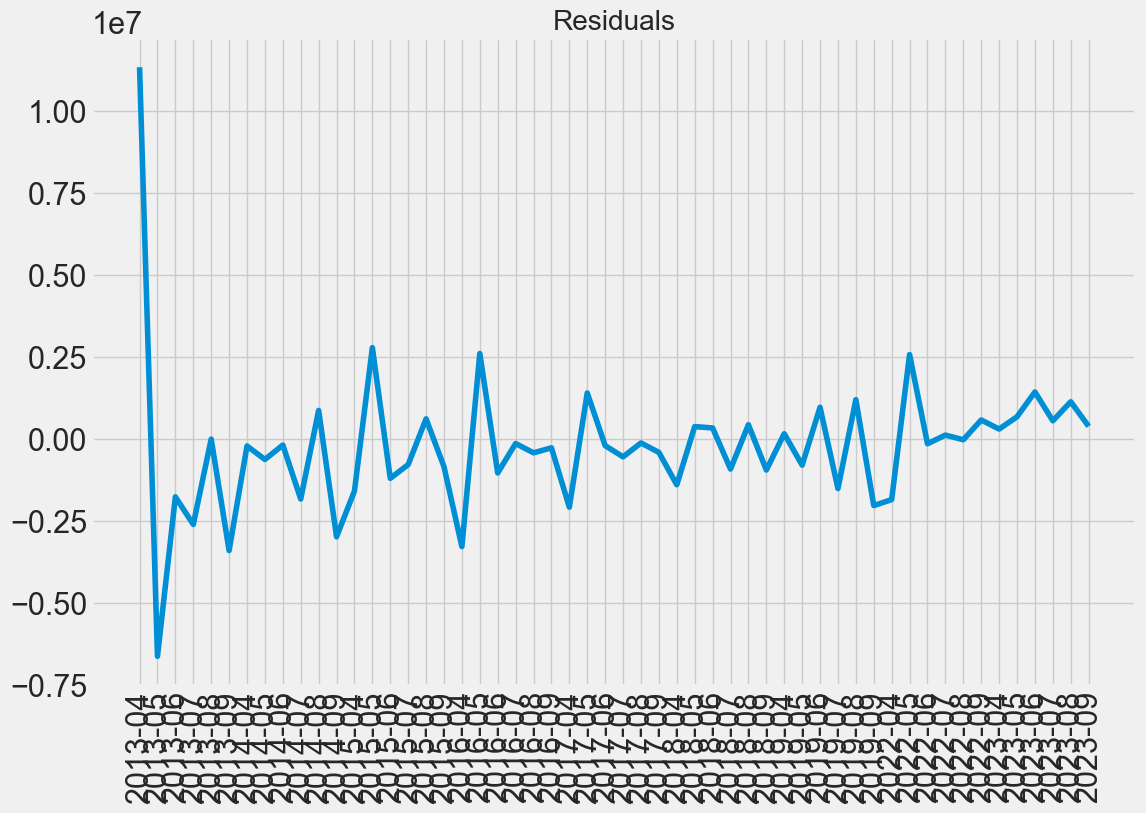

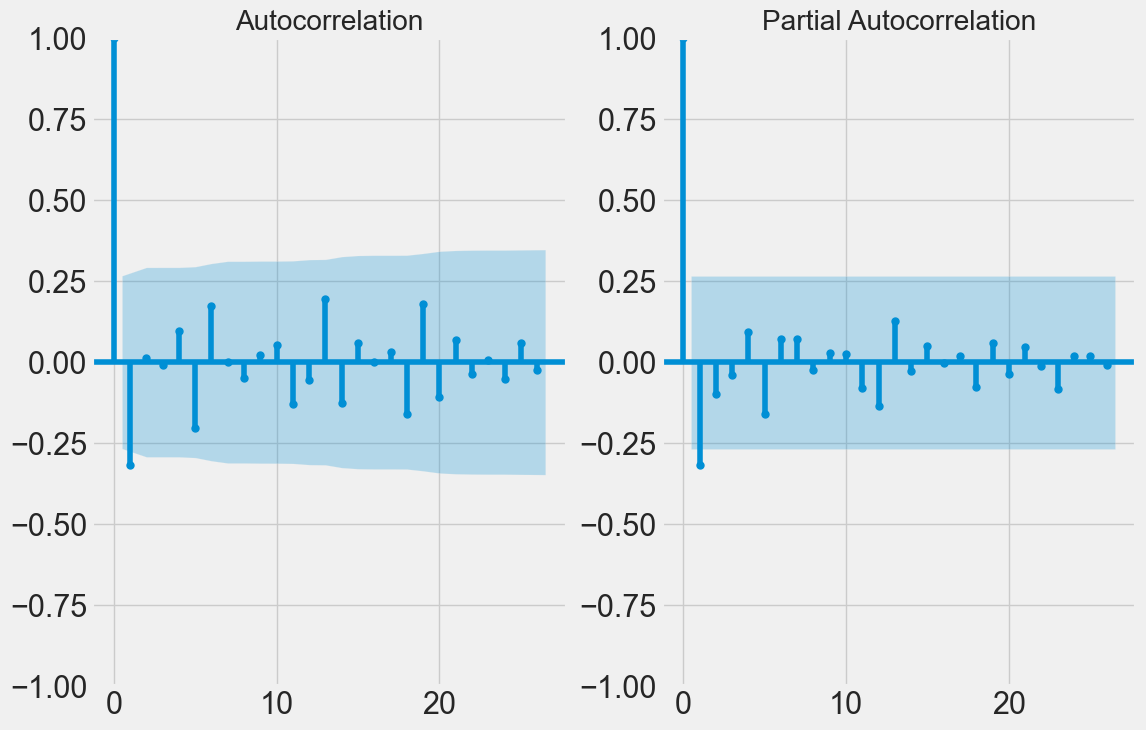

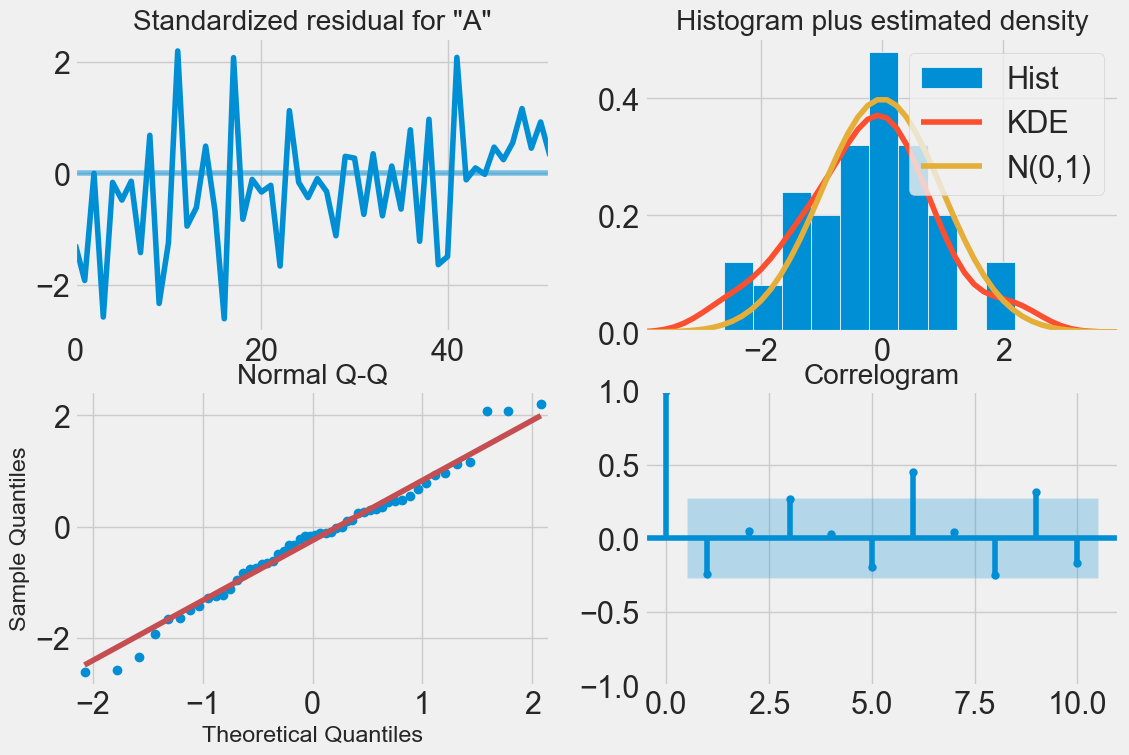

In [48]:
its_sarimax.plot_sarimax_params()


## 状態空間モデル

/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `trend` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"
/Users/mototsuguohki/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37629D+01    |proj g|=  5.97921D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   5.979D-07   1.376D+01
  F =   13.762902485088553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


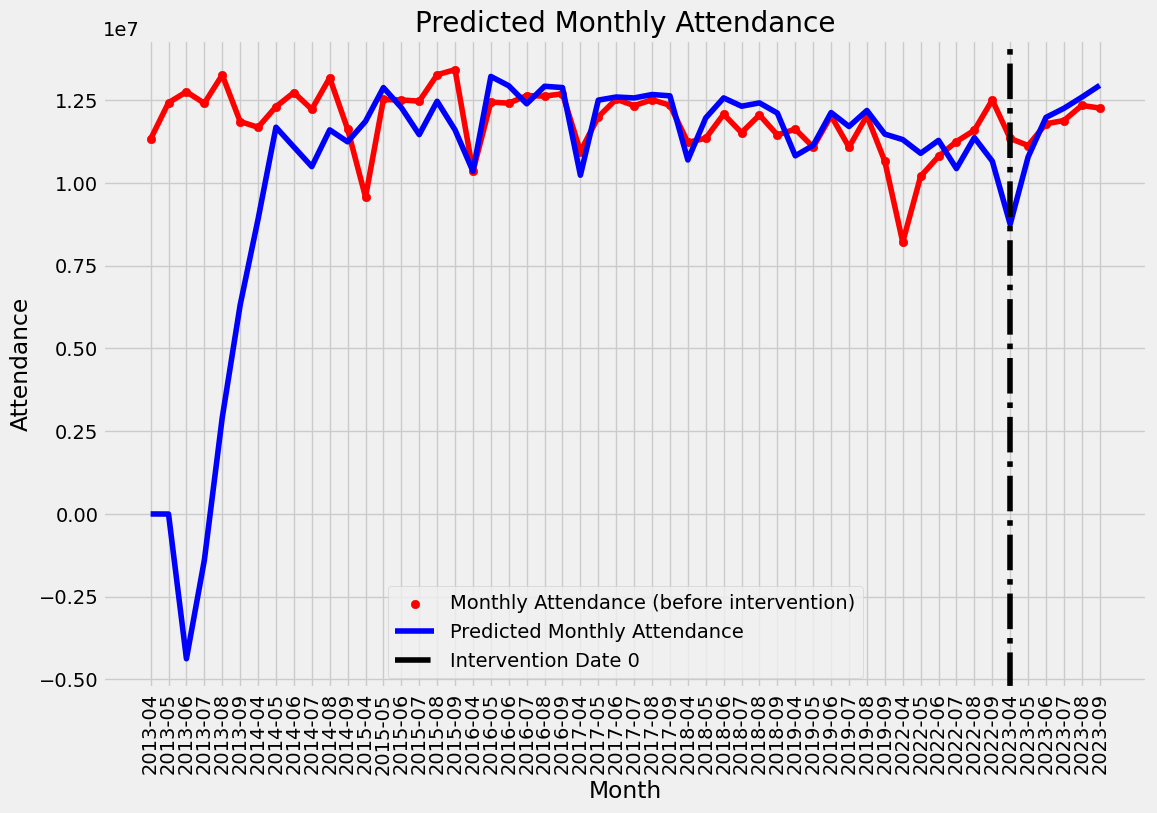

In [5]:
its_state_space = MITS(df_att_remove_covid_addup, interventions=['2023-04'], method='State Space Model')
its_state_space.plot_predict()

In [4]:
its_state_space.show_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Unobserved Components Results                            
====================================================================================
Dep. Variable:                   Attendance   No. Observations:                   54
Model:                          local level   Log Likelihood                -743.197
                   + stochastic seasonal(6)   AIC                           1498.393
Date:                      Sun, 12 Nov 2023   BIC                           1509.621
Time:                              21:48:43   HQIC                          1502.636
Sample:                                   0                                         
                                       - 54                                         
Covariance Type:                        opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sigma2.irregular       6.533e+11   4.96e+11      1.316      0.188    -3.2e+11    1.63e+12
sigma2.level           1.434e+11   5.74e+10      2.496      0.013    3.08e+10    2.56e+11
sigma2.seasonal        6.533e+11   5.28e+11      1.238      0.216   -3.81e+11    1.69e+12
beta.time since start -1898.6808   1.19e+05     -0.016      0.987   -2.35e+05    2.31e+05
beta.level change 0   -3.328e+05   2.01e+06     -0.166      0.868   -4.27e+06     3.6e+06
beta.slope change 0    1.868e+05   1.03e+06      0.181      0.857   -1.84e+06    2.21e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.60   Jarque-Bera (JB):                 4.85
Prob(Q):                              0.00   Prob(JB):                         0.09
Heteroskedasticity (H):               0.77   Skew:                             0.21
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""